# Prueba ML Engineer - Juan Sebastian Rojas Melendez

## Librerias

In [1]:
#Se importan las librerías necesarias para el problema
import category_encoders as ce
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from statsmodels.stats.contingency_tables import mcnemar

warnings.filterwarnings('ignore')

/home/juan/.virtualenvs/experiments/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargando datos
En primer lugar, vamos a cargar el dataset generado por el data scientist que se utilizó para entrenar los modelos.

In [2]:
# Loading the dataset genere
df = pd.read_csv('dataset_DS.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   OPERA      68206 non-null  object
 1   MES        68206 non-null  int64 
 2   TIPOVUELO  68206 non-null  object
 3   SIGLADES   68206 non-null  object
 4   DIANOM     68206 non-null  object
 5   atraso_15  68206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.1+ MB


* **OPERA** : Nombre de aerolínea que opera.
* **MES** : Número de mes de operación del vuelo.
* **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional.
* **DIANOM** : Día de la semana de operación del vuelo.
* **SIGLADES** : Nombre ciudad destino.
* **atraso_15** : 1 si **dif_min** > 15, 0 si no (variable objetivo).

## 1. Escoger el modelo que a tu criterio tenga un mejor performance, argumentando la decisión.

En cuanto a **Experimentación** el Data Scientist escoge dos modelos: logistic regression y Xgboost a partir de su conocimiento y afirmando que ambos modelos son simples y ofrecen buen desempeño. Sin embargo, en sus procesos de entrenamiento no realiza validación cruzada (cross validation) para obtener resultados más cercanos a la realidad en cuanto a las metricas de desempeño. Vamos a intentar comparar ambos modelos con validación cruzada para así tener una mejor perspectiva de cual puede ser mejor.

### Logistic Regression

Los resultados reportados por el data scientist son los siguientes:

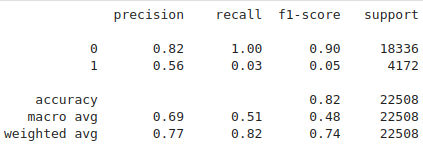

Vamos a observar que resultados se obtienen cuando se aplica cross validation al entrenamiento del modelo de logistic regression:

In [3]:
# Preprocessing data established by the data scientist
X = pd.concat([pd.get_dummies(df['OPERA'], prefix = 'OPERA'),pd.get_dummies(df['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(df['MES'], prefix = 'MES')], axis = 1)
y = df['atraso_15']

# Create your logistic regression model
logreg = LogisticRegression()

# Create a StratifiedKFold cross-validator with balanced class weights
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform balanced cross-validation
accuracy_scores = []
reports = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model with balanced class weights
    logreg.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = logreg.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Obtain confusion matrix
    cf = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the accuracy score
    accuracy_scores.append(accuracy)
    # Store the confusion matrix
    reports.append(cf)

# Calculate and print the average accuracy score across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
sdt_accuracy = np.std(accuracy_scores)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Standard Deviation accuracy: {sdt_accuracy:.4f}')

Average accuracy: 0.8159
Standard Deviation accuracy: 0.0013


In [4]:
# Analyze the aggregated classification reports
# For example, you can calculate the average metrics across all folds
avg_precision = sum([cr['accuracy'] for cr in reports]) / len(reports)
avg_recall = sum([cr['macro avg']['recall'] for cr in reports]) / len(reports)
avg_f1_score = sum([cr['macro avg']['f1-score'] for cr in reports]) / len(reports)

# Print the aggregated results
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1_score)

Average Precision: 0.8158519897797083
Average Recall: 0.5118242374651862
Average F1-score: 0.4767868970861177


### XGBoost
Los resultados reportados por el data scientist son los siguientes:

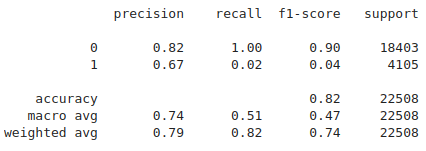

Vamos a observar que resultados se obtienen cuando se aplica cross validation al entrenamiento del modelo de xgboost:

In [5]:
# Preprocessing data established by the data scientist
X = pd.concat([pd.get_dummies(df['OPERA'], prefix = 'OPERA'),pd.get_dummies(df['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(df['MES'], prefix = 'MES')], axis = 1)
y = df['atraso_15']

# Creating xgboost model
modelxgb = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

# Create a StratifiedKFold cross-validator with balanced class weights
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform balanced cross-validation
accuracy_scores = []
reports = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model with balanced class weights
    modelxgb.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = modelxgb.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Obtain confusion matrix
    cf = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the accuracy score
    accuracy_scores.append(accuracy)
    # Store the confusion matrix
    reports.append(cf)

# Calculate and print the average accuracy score across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
sdt_accuracy = np.std(accuracy_scores)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Standard Deviation accuracy: {sdt_accuracy:.4f}')

Average accuracy: 0.8175
Standard Deviation accuracy: 0.0008


In [6]:
# Analyze the aggregated classification reports
# For example, you can calculate the average metrics across all folds
avg_precision = sum([cr['accuracy'] for cr in reports]) / len(reports)
avg_recall = sum([cr['macro avg']['recall'] for cr in reports]) / len(reports)
avg_f1_score = sum([cr['macro avg']['f1-score'] for cr in reports]) / len(reports)

# Print the aggregated results
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1_score)

Average Precision: 0.8174647446797259
Average Recall: 0.5106685962189371
Average F1-score: 0.4725050567399383


### Prueba de significancia

Con los anteriores resultados podemos observar que, utilizando cross validation, ambos modelos dan resultados consistentes con lo que el Data Scientist reportó en sus pruebas y además ambos modelos tienen resultados muy similares aun con un entrenamiento usando cross validation.

Teniendo en cuenta que ambos modelos obtienen resultados muy cercanos en las metricas de desempeño, es importante realizar una prueba de significancia estadística para decidir cual de los dos es mejor. Para este caso vamos a utilizar la **prueba de Mcnemar**. Al comparar dos modelos XGBoost y Regresión Logística, la prueba de McNemar se puede utilizar para determinar si existe una diferencia estadísticamente significativa en su desempeño en términos de predecir el mismo conjunto de muestras. Además, como no hay una diferencia considerable entre el proceso de entrenamiento sin validación cruzada (realizado por el data scientist) y el proceso de entrenamiento con cross validation, utilizaremos el proceso del data scientist a continuación.

In [7]:
# Preprocessing data established by the data scientist
X = pd.concat([pd.get_dummies(df['OPERA'], prefix = 'OPERA'),pd.get_dummies(df['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(df['MES'], prefix = 'MES')], axis = 1)
y = df['atraso_15']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate the contingency table
table = np.array([y_test.values,
                  y_pred_logreg,
                  y_pred_xgb])
contingency_table = mcnemar(table)


# Print the result
print("McNemar's test p-value:", contingency_table.pvalue)

# Perform a significance test at a significance level of 0.05
alpha = 0.05
if contingency_table.pvalue < alpha:
    print("There is a statistically significant difference between the two models.")
else:
    print("There is no statistically significant difference between the two models.")


McNemar's test p-value: 1.0
There is no statistically significant difference between the two models.


La prueba estadistica nos indica que no hay diferencia significativa entre los modelos. Por lo tanto, podemos decidir usando el **AIC (Akaike Information Criterion)** que indica el nivel de complejidad de cada modelo. En este caso, el modelo que tenga un menor AIC sera el modelo menos complejo y por ende el mejor para la tarea en cuestión.

### AIC

In [9]:
def calculate_aic(model, X_train, y_train):
    # Obtain the AIC value
    model_aic = 2 * (model.score(X_train, y_train) - model.score(X_train, model.predict(X_train))) + 2 * X_train.shape[1]
    return model_aic

log_reg_aic = calculate_aic(logreg, X_train, y_train)
xgboost_aic = calculate_aic(xgb_model, X_train, y_train)
print(f'AIC de logistic regression: {log_reg_aic}')
print(f'AIC de xgboost: {xgboost_aic}')

AIC de logistic regression: 73.63009322070988
AIC de xgboost: 73.63333187448028


En vista de que todas las metricas evaluadas no demuestran una diferencia significativa, es mejor elegir el modelo que sea más robusto por concepto y que este mejor capacitado para evitar futuros overfittings. Por lo tanto, para este caso, **se escoge el modelo xgboost**.

## 2. Implementar mejoras sobre el modelo escogiendo la o las técnicas que prefieras.

### Binary Encoder

Una de las mejoras que podemos intentar es utilizar otro encoder que no sea generado a partir de la función get_dummies() ya que este metodo de codificación genera una alta dimensionalidad en los datos de entrenamiento. Por lo tanto, podemos realizar un entrenamiento con un **Binary Encoder** y analizar si obtenemos mejores resultados.

In [19]:
# Create an instance of BinaryEncoder
encoder = ce.BinaryEncoder()

# Apply binary encoding to the dataframe
df_encoded = encoder.fit_transform(df.loc[:, df.columns != 'atraso_15'])

# Show the original dataframe
print("Original DataFrame:")
display(df)

# Show the dataframe after binary encoding
print("\nDataFrame after Binary Encoding:")
display(df_encoded)

Original DataFrame:


,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM,atraso_15
0,Sky Airline,3,N,Antofagasta,Viernes,0
1,Grupo LATAM,7,N,Concepcion,Jueves,0
2,Grupo LATAM,9,N,Arica,Miercoles,0
3,Grupo LATAM,11,N,Iquique,Viernes,0
4,Sky Airline,5,N,Valdivia,Lunes,0
...,...,...,...,...,...,...
68201,Grupo LATAM,7,I,Sao Paulo,Domingo,0
68202,Sky Airline,6,N,La Serena,Viernes,1
68203,Grupo LATAM,5,N,Temuco,Domingo,0
68204,Grupo LATAM,1,I,Buenos Aires,Jueves,0



DataFrame after Binary Encoding:


,OPERA_0,OPERA_1,OPERA_2,OPERA_3,OPERA_4,MES,TIPOVUELO_0,TIPOVUELO_1,SIGLADES_0,SIGLADES_1,SIGLADES_2,SIGLADES_3,SIGLADES_4,SIGLADES_5,DIANOM_0,DIANOM_1,DIANOM_2
0,0,0,0,0,1,3,0,1,0,0,0,0,0,1,0,0,1
1,0,0,0,1,0,7,0,1,0,0,0,0,1,0,0,1,0
2,0,0,0,1,0,9,0,1,0,0,0,0,1,1,0,1,1
3,0,0,0,1,0,11,0,1,0,0,0,1,0,0,0,0,1
4,0,0,0,0,1,5,0,1,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,0,0,0,1,0,7,1,0,0,1,0,0,1,1,1,0,1
68202,0,0,0,0,1,6,0,1,0,1,0,1,0,1,0,0,1
68203,0,0,0,1,0,5,0,1,0,0,1,1,0,0,1,0,1
68204,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0


Con este metodo pasamos de tener 37 columnas a 18 columnas reduciendo considerablemente la dimensionalidad del dataset de entrenamiento. Ahora vamos a analizar si las metricas de desempeño cambian.

In [11]:
# Preprocessing data established by the data scientist
X = df_encoded.loc[:, df_encoded.columns != 'atraso_15']
y = df_encoded['atraso_15']

# Creating xgboost model
modelxgb = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

# Create a StratifiedKFold cross-validator with balanced class weights
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform balanced cross-validation
accuracy_scores = []
reports = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model with balanced class weights
    modelxgb.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = modelxgb.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Obtain confusion matrix
    cf = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the accuracy score
    accuracy_scores.append(accuracy)
    # Store the confusion matrix
    reports.append(cf)

# Calculate and print the average accuracy score across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
sdt_accuracy = np.std(accuracy_scores)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Standard Deviation accuracy: {sdt_accuracy:.4f}')

Average accuracy: 0.8151
Standard Deviation accuracy: 0.0003


In [12]:
# Analyze the aggregated classification reports
# For example, you can calculate the average metrics across all folds
avg_precision = sum([cr['accuracy'] for cr in reports]) / len(reports)
avg_recall = sum([cr['macro avg']['recall'] for cr in reports]) / len(reports)
avg_f1_score = sum([cr['macro avg']['f1-score'] for cr in reports]) / len(reports)

# Print the aggregated results
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1_score)

Average Precision: 0.8151189078406731
Average Recall: 0.500618177686859
Average F1-score: 0.45055755625431326


Teniendo en cuenta que para el caso con 37 variables la precision del modelo fue de 81.74% y para este caso con 18 variables tomadas a partir del Binary Encoder la precisión fue de 81.51% podemos trabajar con el dataset procesado con el Binary Encoder ya que reduce dimensionalidad del dataset sin perder performance de manera significativa.

### Hyperparameter tuning - Optuna

En el trabajo realizado por el data scientist, se encontró que se intentó una optimización de hiperparámetros utilizando el metodo **GridSearch**. Este metodo aunque muy conocido, es el más pesado computacionalmente y no permite probar multiples combinaciones de hiperparametros que quizas permitan encontrar un mejor desempeño en el modelo. Optuna, es una libreria que permite realizar esa optimización sin ser tan demandante en recursos computacionales. Vamos a probar si es posible encontrar un mejor resultado al optimizar con Optuna.

In [13]:
# Preprocessing data established by the data scientist
X = df_encoded.loc[:, df_encoded.columns != 'atraso_15']
y = df_encoded['atraso_15']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
    }

    # Create an XGBoost classifier with the hyperparameters
    clf = xgb.XGBClassifier(**params)

    # Train and evaluate the classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=False)

# Get the best hyperparameters from the study
best_params = study.best_params
print(f"The best performance was obtained with this parameters: {best_params}")

[I 2023-04-21 20:27:32,614] A new study created in memory with name: no-name-ce65e0df-327a-405c-982a-a054fb02e012
[I 2023-04-21 20:27:33,685] Trial 0 finished with value: 0.8209969788519638 and parameters: {'n_estimators': 70, 'max_depth': 7, 'learning_rate': 0.060257428006326524, 'gamma': 0.014321082927695381, 'min_child_weight': 7, 'subsample': 0.8772699385930416, 'colsample_bytree': 0.8527662913690989}. Best is trial 0 with value: 0.8209969788519638.
[I 2023-04-21 20:27:35,718] Trial 1 finished with value: 0.8201084059001243 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.0499142114652393, 'gamma': 0.10979972263841918, 'min_child_weight': 3, 'subsample': 0.5649270711819377, 'colsample_bytree': 0.9151641071483769}. Best is trial 0 with value: 0.8209969788519638.
[I 2023-04-21 20:27:36,951] Trial 2 finished with value: 0.8176204016349742 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.014925511222978905, 'gamma': 0.010580989627476724, 

The best performance was obtained with this parameters: {'n_estimators': 70, 'max_depth': 8, 'learning_rate': 0.025735596358688977, 'gamma': 0.031418857979262575, 'min_child_weight': 9, 'subsample': 0.7191058221452544, 'colsample_bytree': 0.8677287925772513}


Ahora vamos a entrenar el modelo con cross validation y esos hiperparámetros para observar si obtenemos un mejor desempeño.

In [14]:
# Preprocessing data established by the data scientist
X = df_encoded.loc[:, df_encoded.columns != 'atraso_15']
y = df_encoded['atraso_15']

# Creating xgboost model
modelxgb = xgb.XGBClassifier(**best_params, random_state=1)

# Create a StratifiedKFold cross-validator with balanced class weights
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform balanced cross-validation
accuracy_scores = []
reports = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model with balanced class weights
    modelxgb.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = modelxgb.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Obtain confusion matrix
    cf = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the accuracy score
    accuracy_scores.append(accuracy)
    # Store the confusion matrix
    reports.append(cf)

# Calculate and print the average accuracy score across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
sdt_accuracy = np.std(accuracy_scores)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Standard Deviation accuracy: {sdt_accuracy:.4f}')

Average accuracy: 0.8182
Standard Deviation accuracy: 0.0012


Teniendo en cuenta que para el caso **con 37 variables la precision del modelo fue de 81.74%**, despues de la optimización de hiperparámetros con Optuna **la precisión subio a 81.82%** manteniendo **menos dimensionalidad** en el dataset de entrenamiento (**18 variables**)

Ahora vamos a guardar el modelo entrenado y el Binary Encoder para usarlos en la API

## Generando el modelo con Binary Encoder con Joblib para la API

In [20]:
# Save the encoder object to a file
joblib.dump(encoder, 'binary_encoder.pkl')

['binary_encoder.pkl']

## Generando el modelo con Joblib para la API

In [16]:
# Preprocessing data established by the data scientist
X = df_encoded.loc[:, df_encoded.columns != 'atraso_15']
y = df_encoded['atraso_15']

# Creating xgboost model
modelxgb = xgb.XGBClassifier(**best_params, random_state=1)
modelxgb = modelxgb.fit(X, y)

# Save the model using joblib
joblib.dump(modelxgb, 'xgboost_model.joblib')

['xgboost_model.joblib']

**Los demás requerimientos de la prueba se encuentran en un script que crea y permite consumir el modelo a partir de un API creada con FastAPI.**